In [9]:
import msprime
import tskit
import numpy as np
import random

# 1. Simulation parameters
sample_size = 20
effective_population_size = 10_000
mutation_rate = 2e-8

# 2. Define the genome with 3 chromosomes
chromosome_lengths = [1_500_000, 1_000_000, 500_000]
recombination_rate_per_chr = 2e-8

# CORRECTED SECTION:
# First, define the chromosome boundaries. The total length is the sum of all chromosome lengths.
# The `position` list starts at 0 and marks the end of each chromosome.
total_length = sum(chromosome_lengths)
positions = [0] + list(np.cumsum(chromosome_lengths))

# The `rate` list must be one element shorter than the `positions` list.
# It contains the recombination rate for each segment (chromosome).
# Here, we have a uniform rate, but you could have different rates for each chromosome.
rates = [recombination_rate_per_chr] * len(chromosome_lengths)

# Create the RateMap directly from the positions and rates
rate_map = msprime.RateMap(position=positions, rate=rates)


# 3. Parameters for SNP chip
MAF_THRESHOLD = 0.05
NUM_CHIP_SNPS = 20

# 4. Run the simulation using the rate_map
ts = msprime.sim_ancestry(
    samples=sample_size,
    population_size=effective_population_size,
    recombination_rate=rate_map,
    random_seed=42
)
mts = msprime.sim_mutations(
    ts,
    rate=mutation_rate,
    random_seed=42
)

# 5. Filter and select SNPs
selectable_snps = []
for var in mts.variants():
    if len(var.alleles) == 2:
        f = np.mean(var.genotypes)
        maf = min(f, 1 - f)
        if maf > MAF_THRESHOLD:
            selectable_snps.append(var)

num_to_select = min(NUM_CHIP_SNPS, len(selectable_snps))
selected_snps = random.sample(selectable_snps, num_to_select)
selected_snps.sort(key=lambda v: v.site.position)


# 6. Create the genetic map and haplotype vectors, mapping back to chromosomes
print("--- Genetic Map and Haplotypes for 3 Chromosomes ---")

def get_chrom_pos(genome_pos, rate_map):
    chr_index = rate_map.find_index(genome_pos)
    chr_start = rate_map.left[chr_index]
    local_pos = genome_pos - chr_start
    return (chr_index + 1, int(local_pos))

genetic_map = [get_chrom_pos(v.site.position, rate_map) for v in selected_snps]

print("Genetic Map (Chr, Position):")
print(genetic_map)
print("\n")


for i in range(mts.num_individuals):
    haplotype1_vector = [snp.genotypes[2 * i] for snp in selected_snps]
    haplotype2_vector = [snp.genotypes[2 * i + 1] for snp in selected_snps]

    print(f"Individual {i}:")
    print(f"  Haplotype 1: {haplotype1_vector}")
    print(f"  Haplotype 2: {haplotype2_vector}\n")

--- Genetic Map and Haplotypes for 3 Chromosomes ---
Genetic Map (Chr, Position):
[(np.int64(1), 148574), (np.int64(1), 161156), (np.int64(1), 168134), (np.int64(1), 230861), (np.int64(1), 296372), (np.int64(1), 404475), (np.int64(1), 458306), (np.int64(1), 526768), (np.int64(1), 720381), (np.int64(1), 1038824), (np.int64(1), 1479145), (np.int64(2), 61949), (np.int64(2), 426043), (np.int64(2), 697355), (np.int64(2), 779976), (np.int64(2), 877479), (np.int64(2), 900323), (np.int64(2), 913296), (np.int64(3), 337812), (np.int64(3), 419516)]


Individual 0:
  Haplotype 1: [np.int32(0), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]
  Haplotype 2: [np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.in


--- Calculating and Plotting LD ---


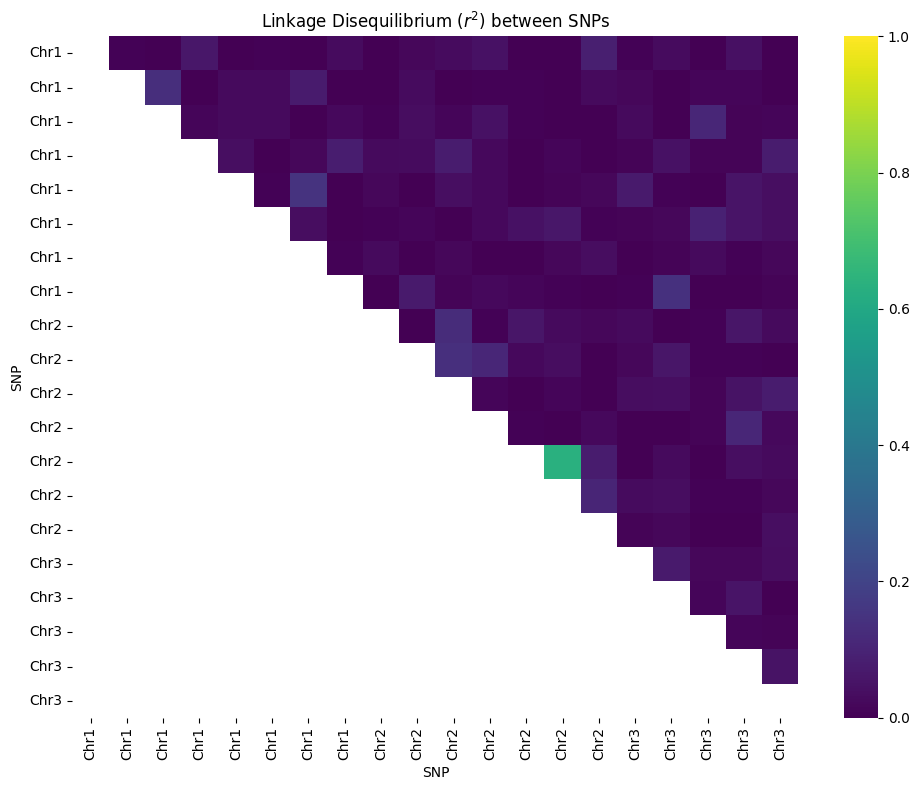

In [8]:
import msprime
import tskit
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Simulation parameters
sample_size = 20
effective_population_size = 10_000
mutation_rate = 2e-8

# 2. Define the genome with 3 chromosomes
chromosome_lengths = [1_500_000, 1_000_000, 500_000]
recombination_rate_per_chr = 2e-8

total_length = sum(chromosome_lengths)
positions = [0] + list(np.cumsum(chromosome_lengths))
rates = [recombination_rate_per_chr] * len(chromosome_lengths)
rate_map = msprime.RateMap(position=positions, rate=rates)

# 3. Parameters for SNP chip
MAF_THRESHOLD = 0.05
NUM_CHIP_SNPS = 20

# 4. Run the simulation using the rate_map
ts = msprime.sim_ancestry(
    samples=sample_size,
    population_size=effective_population_size,
    recombination_rate=rate_map,
    random_seed=42
)
mts = msprime.sim_mutations(
    ts,
    rate=mutation_rate,
    random_seed=42
)

# 5. Filter and select SNPs
selectable_snps = []
for var in mts.variants():
    if len(var.alleles) == 2:
        f = np.mean(var.genotypes)
        maf = min(f, 1 - f)
        if maf > MAF_THRESHOLD:
            selectable_snps.append(var)

num_to_select = min(NUM_CHIP_SNPS, len(selectable_snps))
selected_snps = random.sample(selectable_snps, num_to_select)
selected_snps.sort(key=lambda v: v.site.position)

# 6. Create the genetic map (needed for the plot labels)
def get_chrom_pos(genome_pos, rate_map):
    chr_index = rate_map.find_index(genome_pos)
    return chr_index + 1

# 7. Calculate and visualize LD
print("\n--- Calculating and Plotting LD ---")

# --- FINAL CORRECTED SECTION ---
# Get the IDs of the SNPs we want to KEEP
selected_site_ids = {v.site.id for v in selected_snps} # Use a set for fast lookups

# Find all site IDs in the tree sequence that we want to DELETE
all_site_ids = [site.id for site in mts.sites()]
sites_to_delete = [site_id for site_id in all_site_ids if site_id not in selected_site_ids]

# Create the filtered tree sequence by deleting the unwanted sites
filtered_mts = mts.delete_sites(sites_to_delete)

# Now, initialize the calculator with the correctly filtered tree sequence
ld_calc = tskit.LdCalculator(filtered_mts)

# Call r2_matrix() without any arguments.
r2_matrix = ld_calc.r2_matrix()
# --- END FINAL CORRECTED SECTION ---

# Get chromosome labels for the plot
# We must get the labels from the sorted 'selected_snps' list to ensure correct order
snp_chrom_labels = [f"Chr{get_chrom_pos(v.site.position, rate_map)}" for v in selected_snps]

# Mask the lower triangle for better visualization
mask = np.tril(np.ones_like(r2_matrix, dtype=bool))

# Plot the LD heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix,
    mask=mask,
    cmap="viridis",
    xticklabels=snp_chrom_labels,
    yticklabels=snp_chrom_labels,
    vmin=0, 
    vmax=1 # Set color scale from 0 to 1 for r^2
)
plt.title("Linkage Disequilibrium ($r^2$) between SNPs")
plt.xlabel("SNP")
plt.ylabel("SNP")
plt.xticks(rotation=90) # Rotate labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# (Add this after your existing code)

# 7. Calculate and visualize LD

# Get the genomic positions of the selected SNPs
snp_positions = [v.site.position for v in selected_snps]
snp_map = [genetic_map[i][0] for i in range(len(selected_snps))] # Chromosome number for each SNP

# Use tskit's LD calculator
ld_calc = tskit.LdCalculator(mts)
r2_matrix = ld_calc.r2_matrix(indexes=[v.site.id for v in selected_snps])

# Mask the lower triangle for better visualization
mask = np.tril(np.ones_like(r2_matrix, dtype=bool))

# Plot the LD heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix,
    mask=mask,
    cmap="viridis",
    xticklabels=snp_map,
    yticklabels=snp_map
)
plt.title("Linkage Disequilibrium ($r^2$) between SNPs")
plt.xlabel("Chromosome of SNP")
plt.ylabel("Chromosome of SNP")
plt.tight_layout()
plt.show()

NameError: name 'selected_snps' is not defined

Simulated 300 individuals with 13718 variable sites.

Created genotype matrix with shape: (300, 13718)
(rows=individuals, columns=SNPs)

PCA plot saved as 'pca_plot_closely_related.png'

Exporting data files...
Data export complete.
- diploid_genotypes.csv
- individual_labels.txt
- haplotype_1.csv
- haplotype_2.csv


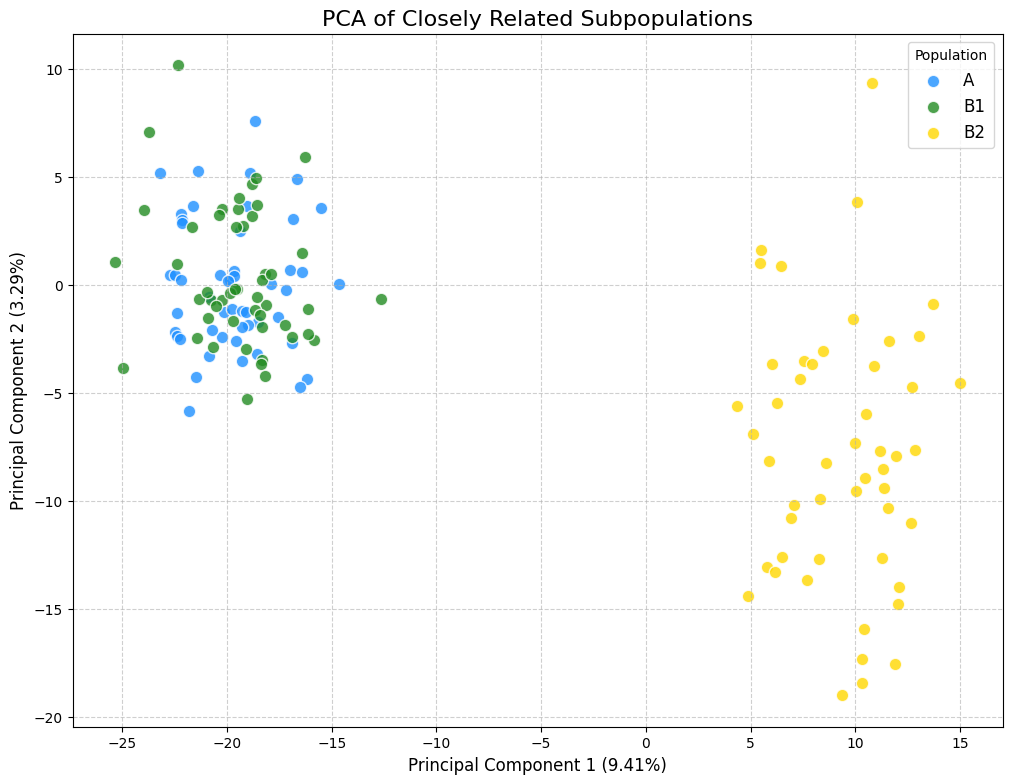

In [2]:
import msprime
import tskit
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Define the demographic model with MORE RECENT splits
demography = msprime.Demography()
demography.add_population(name="ANC", initial_size=10_000)
demography.add_population(name="A", initial_size=5_000)
demography.add_population(name="B", initial_size=5_000)
demography.add_population(name="B1", initial_size=2_500)
demography.add_population(name="B2", initial_size=2_500)

# The splits are now much closer in time and more recent
# This will result in less distinct, overlapping clusters.
demography.add_population_split(time=200, derived=["B1", "B2"], ancestral="B")
demography.add_population_split(time=1000, derived=["A", "B"], ancestral="ANC")

# Define the number of individuals to sample from each population
samples = { "A": 100, "B1": 100, "B2": 100 } # Reduced for faster run time

ts = msprime.sim_ancestry(
    samples=samples,
    demography=demography,
    recombination_rate=1e-8,
    sequence_length=5_000_000,
    random_seed=2024 # Changed seed to get a new outcome
)
mts = msprime.sim_mutations(ts, rate=1e-8, random_seed=2024)

print(f"Simulated {mts.num_individuals} individuals with {mts.num_sites} variable sites.\n")

# 2. Get the genotype matrix and labels for each individual
genotype_matrix_haploid = mts.genotype_matrix()
genotype_matrix_diploid = (
    genotype_matrix_haploid[:, 0::2] + genotype_matrix_haploid[:, 1::2]
)
pca_input_matrix = genotype_matrix_diploid.T

individual_labels = []
for pop_name in ["A", "B1", "B2"]:
    individual_labels.extend([pop_name] * (samples[pop_name] // 2))

print(f"Created genotype matrix with shape: {pca_input_matrix.shape}")
print(f"(rows=individuals, columns=SNPs)\n")


# 3. Perform PCA (No changes here)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_input_matrix)

# 4. Plot the results (No changes here)
plt.figure(figsize=(12, 9))
colors = {"A": "dodgerblue", "B1": "forestgreen", "B2": "gold"}

for pop_name in ["A", "B1", "B2"]:
    indices = [i for i, label in enumerate(individual_labels) if label == pop_name]
    plt.scatter(
        pca_result[indices, 0], 
        pca_result[indices, 1], 
        c=colors[pop_name], 
        label=pop_name,
        alpha=0.8, 
        edgecolors='w', 
        s=80
    )

plt.title('PCA of Closely Related Subpopulations', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.legend(title='Population', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("pca_plot_closely_related.png")

print("PCA plot saved as 'pca_plot_closely_related.png'\n")


# 5. EXPORT DATA FOR YOUR BREEDING SOFTWARE
print("Exporting data files...")

# Save the diploid genotype matrix (individuals x SNPs)
np.savetxt("diploid_genotypes.csv", pca_input_matrix, fmt='%d', delimiter=",")

# Save the list of individual labels
with open("individual_labels.txt", "w") as f:
    for label in individual_labels:
        f.write(f"{label}\n")

# Save the two haplotype matrices (individuals x SNPs for each haplotype)
haplotype_1_matrix = genotype_matrix_haploid[:, 0::2].T
haplotype_2_matrix = genotype_matrix_haploid[:, 1::2].T
np.savetxt("haplotype_1.csv", haplotype_1_matrix, fmt='%d', delimiter=",")
np.savetxt("haplotype_2.csv", haplotype_2_matrix, fmt='%d', delimiter=",")

print("Data export complete.")
print("- diploid_genotypes.csv")
print("- individual_labels.txt")
print("- haplotype_1.csv")
print("- haplotype_2.csv")